In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
kq4_data = pd.read_excel('data/KQ4 Workbook.xlsx', sheetname='Sheet1', na_values=['NR', 'NA']).drop(['Notes'], axis=1)
kq4_data.head()

,Author,RefID,LMS Total,Pre-op,Initial Surgery,Morcellation,Power,Cancer Stage,Upstaged,Months follow-up,Outcome,Age,Menopausal Status
0,Einstein,405.0,5.0,Benign,LSC SCC,Yes,Yes,I,No,30.0,NED,NaN,NaN
1,Einstein,405.0,NaN,Benign,LMYOM,Yes,Yes,I to III,Yes,61.0,NED,NaN,NaN
2,Einstein,405.0,NaN,Benign,SCH,Yes,No,I to III,Yes,31.0,AWD,NaN,NaN
3,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I,No,37.0,NED,NaN,NaN
4,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I to IV,Yes,6.0,AWD,NaN,NaN


Some studies show event time truncated to the end of the followup period

In [5]:
followup_event_time = ['Lin', 'Perri', 'Park']
kq4_data['followup_event_time'] = kq4_data.Author.isin(followup_event_time)
kq4_data.followup_event_time.value_counts()

True     127
False     70
Name: followup_event_time, dtype: int64

In [6]:
kq4_data.isnull().mean().round(2)

Author                 0.00
RefID                  0.48
LMS Total              0.91
Pre-op                 0.19
Initial Surgery        0.01
Morcellation           0.01
Power                  0.22
Cancer Stage           0.17
Upstaged               0.81
Months follow-up       0.14
Outcome                0.01
Age                    0.27
Menopausal Status      0.46
followup_event_time    0.00
dtype: float64

In [7]:
kq4_data = kq4_data.dropna(axis='rows', subset=['Months follow-up'])

In [8]:
kq4_data.Outcome.value_counts()

Alive    78
Dead     51
NED      20
AWD      13
Died      8
Name: Outcome, dtype: int64

In [9]:
kq4_data['Pre-op'].value_counts()

Benign    133
Name: Pre-op, dtype: int64

In [10]:
pd.crosstab(kq4_data.Morcellation, kq4_data.Power)

Power,No,Yes
Morcellation,,
No,76,0
Yes,22,30


In [11]:
kq4_data['Initial Surgery'].value_counts()

TAH            73
LSC ASST VH    18
ABD MYOM       12
LSC SCH        11
LSC TVH         8
Varied          7
LSC HYST        6
H'SCOPE MYO     6
LSC MYOM        6
SCH             5
LMYOM           3
VAG HYST        2
MIS HYST        2
TVH             2
LAVH            2
TAH UT INJ      2
SCH BSO         2
Robotic TLH     1
LSC SCC         1
TAH BSO         1
Name: Initial Surgery, dtype: int64

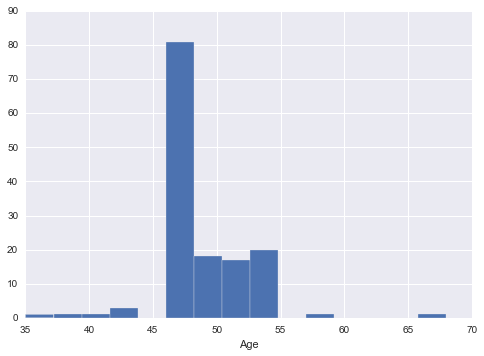

In [12]:
axes = kq4_data.Age.hist(bins=15)
axes.set_xlabel('Age')

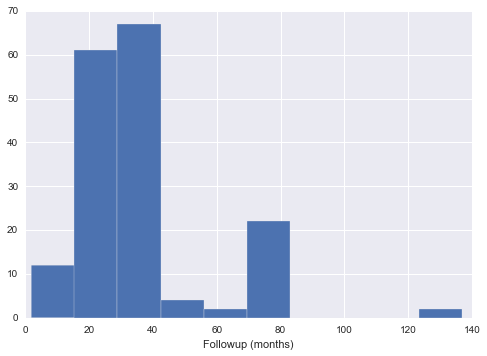

In [13]:
axes = kq4_data['Months follow-up'].hist()
axes.set_xlabel('Followup (months)')

Create death outcome column

In [14]:
kq4_data['died'] = kq4_data.Outcome.isin(['Dead', 'Died'])
kq4_data.loc[kq4_data.Outcome.isnull(), 'died'] = np.nan
kq4_data.died.value_counts()

0.0    111
1.0     59
Name: died, dtype: int64

In [17]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [18]:
kmf.fit(kq4_data['Months follow-up'], event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 170 observations, 111 censored>

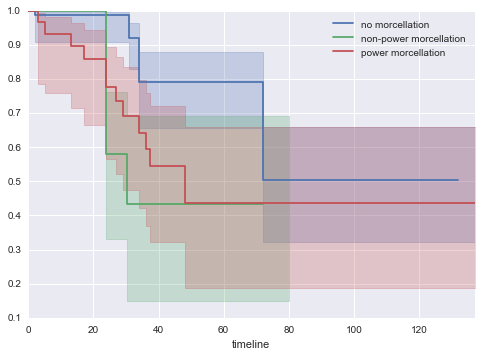

In [19]:
time = kq4_data['Months follow-up']
event = event_observed=kq4_data.died
ix0 = kq4_data.Morcellation=='No'
ix1 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No')
ix2 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')



kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot()

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax)

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax)

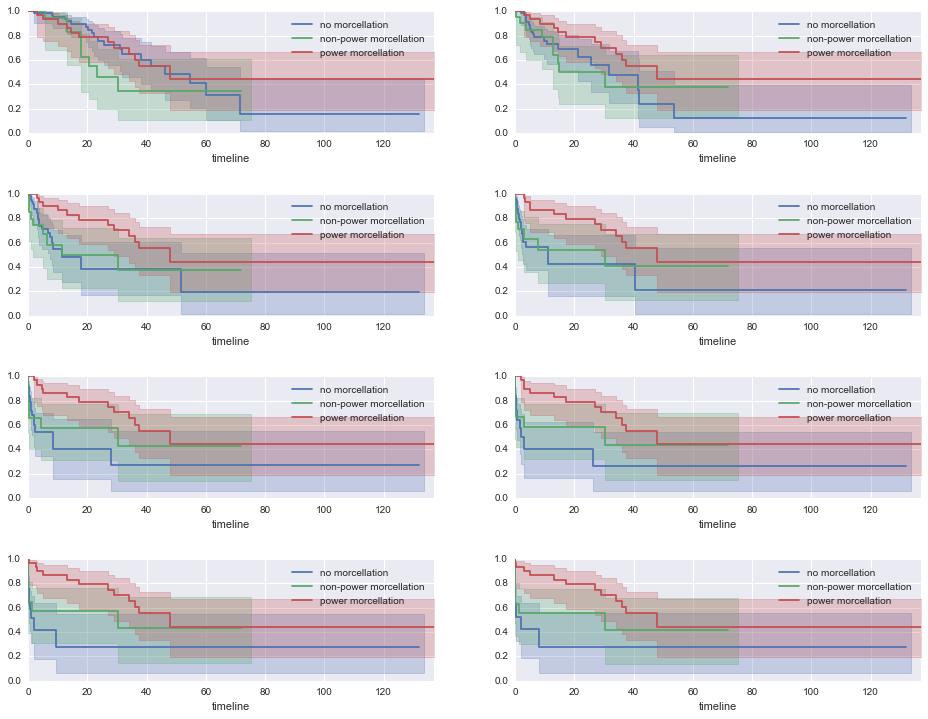

In [36]:
time_sim = kq4_data['Months follow-up'].copy()

fig, axes = plt.subplots(4,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim.loc[kq4_data.followup_event_time] = np.random.uniform(0, time_sim[kq4_data.followup_event_time])
    
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax)

In [27]:
age = kq4_data.Age.copy()
age[kq4_data.Age.isnull()] = -1

In [28]:
from numpy.ma import masked_values
import theano.tensor as T

with pm.Model() as survival_model:
    
    K = 30
    N = kq4_data.shape[0]
    
    alpha_fup = pm.Gamma('alpha_fup', 1., 1.)
    beta_fup = pm.Beta('beta_fup', 1., alpha_fup, shape=K)
    w_fup = pm.Deterministic('w_fup', beta_fup * T.concatenate([[1], T.extra_ops.cumprod(1 - beta_fup[:-1])]))
    fup_component = pm.Categorical('fup_component', w_fup, shape=N)
    
    σ = pm.HalfCauchy('σ', 5, shape=K)
    μ = pm.Normal('μ', 0, 1e-6, shape=K)
    ages = pm.Normal('ages', μ[fup_component], sd=σ[fup_component], observed=masked_values(age, value=-1))                                                           

Applied log-transform to alpha_fup and added transformed alpha_fup_log to model.
Applied logodds-transform to beta_fup and added transformed beta_fup_logodds to model.
Applied log-transform to σ and added transformed σ_log to model.


In [29]:
with survival_model:
#     step1 = pm.Metropolis(vars=survival_model.cont_vars)
#     step = pm.ElemwiseCategoricalStep([fup_component], np.arange(K))
    tr = pm.sample(2000)

Assigned NUTS to alpha_fup_log
Assigned NUTS to beta_fup_logodds
Assigned ElemwiseCategoricalStep to fup_component
Assigned NUTS to σ_log
Assigned NUTS to μ
Assigned NUTS to ages_missing
 [                  0%                  ] 8 of 2000 complete in 24.6 sec

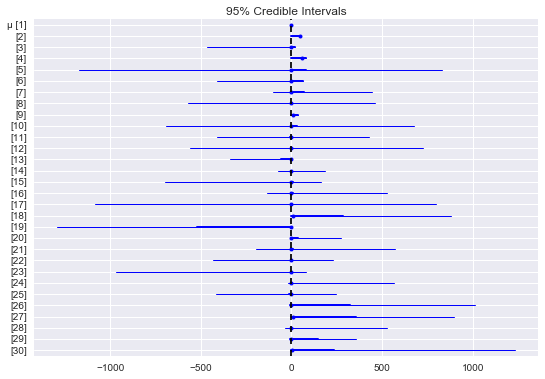

In [30]:
pm.forestplot(tr, varnames=['μ'])

In [31]:
import scipy as sp

x_plot = np.linspace(30, 80, 200)

post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      tr['μ'][:, np.newaxis, :],
                                      1. / np.sqrt(tr['σ'])[:, np.newaxis, :])
post_pdfs = (tr['w_fup'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

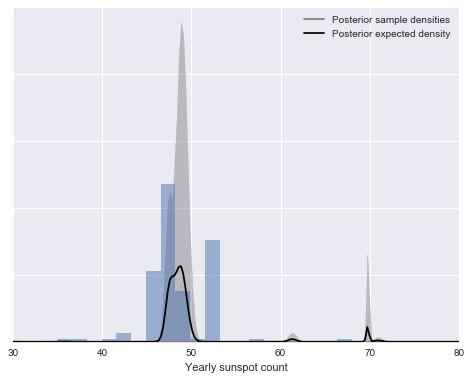

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

# kq4_data.Age.hist(normed=True, ax=ax, lw=0, bins=20, alpha=0.75)
ax.hist(kq4_data.Age.dropna().values, bins=20, normed=True, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::200].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);